## Potential source distributions

[Pringle & Dobbs (2019)](https://arxiv.org/pdf/1909.10291.pdf) propose that for a simple model of spiral awm winding, galaxy pitch angle should be uniform in $\cot\phi$ between some limits. We examine this possibility using repetitions of the [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) and [Anderson-Darling](https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test) tests for different realizations of the posterior distribution of galaxy pitch angle (which we will refer to as _marginalized tests_). We also invsetigate the Beta distribution and Truncated Normal distribution as possible source distributions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.text import Annotation
from matplotlib import rc

import seaborn as sns
from scipy.optimize import minimize
import pymc3 as pm
from tqdm import tqdm
import scipy.stats as st
import corner
import warnings
from IPython.display import Latex
from gzbuilder_analysis import load_fit_results
from hierarchial_model import UniformBHSM, plot_galaxy
warnings.simplefilter('ignore', UserWarning)

In [3]:
fit_results = load_fit_results('lib/tuning_results')

In [4]:
BHSM_OUTPUT_FILE = 'n129d1000t500.pickle'

In [5]:
res = UniformBHSM.load(BHSM_OUTPUT_FILE)
bhsm = res['bhsm']
trace = res['trace']

In [6]:
display(bhsm.model)

In [7]:
gal_pa_samples = pd.DataFrame(
    trace['phi_gal'].T,
    index=bhsm.galaxies.index
)
pa_expectation = gal_pa_samples.mean(axis=1)
pa_std = gal_pa_samples.std(axis=1)

print('N Galaxies:', len(bhsm.galaxies))
print('N Arms:    ', bhsm.n_arms)
print('N Points:  ', bhsm.data.shape[0])

N Galaxies: 129
N Arms:     247
N Points:   238433


In [8]:
n_arm_map = pd.Series(bhsm.gal_n_arms, index=bhsm.galaxies.index)

arm_pa_samples = pd.DataFrame(trace['phi_arm'].T, index=pd.MultiIndex.from_tuples([
    (i, j)
    for i in gal_pa_samples.index
    for j in range(n_arm_map.loc[i])
]))
arm_mean_pas = arm_pa_samples.mean(axis=1)

In [9]:
pa_samples = gal_pa_samples.T.sample(500).unstack()

In [10]:
def cot(phi):
    return 1 / np.tan(np.radians(phi))

def acot(a):
    return np.degrees(np.arctan(1 / a))

def truncnorm(loc, scale, lower=0, upper=90):
    return st.truncnorm(
        (lower - loc) / scale, (upper - loc) / scale,
        loc=loc, scale=scale
    )

def truncnorm_nnlf(loc, scale, data, lower=0, upper=90):
    a, b = (lower - loc) / scale, (upper - loc) / scale
    return st.truncnorm.nnlf((a, b, loc, scale), data)

In [36]:
# Limits from Pringle and Dobbs
LOWER_COT_BOUND_PRINGLE = 1.0
UPPER_COT_BOUND_PRINGLE = 4.75

lower_phi_bound_pringle = acot(UPPER_COT_BOUND_PRINGLE)
upper_phi_bound_pringle = acot(LOWER_COT_BOUND_PRINGLE)
display(Latex(r'${:.2f} < \cot(\phi) < {:.2f}$'.format(LOWER_COT_BOUND_PRINGLE, UPPER_COT_BOUND_PRINGLE)))
display(Latex(r'${:.2f} < \phi < {:.2f}$'.format(lower_phi_bound_pringle, upper_phi_bound_pringle)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Instead of using the limits from Pringle & Dobbs, we adjust our bounds slightly to reflect our different sample galaxies (determined by eye)

In [38]:
LOWER_COT_BOUND = cot(50)
UPPER_COT_BOUND = cot(15)

lower_phi_bound = acot(UPPER_COT_BOUND)
upper_phi_bound = acot(LOWER_COT_BOUND)

display(Latex(r'${:.2f} < \cot(\phi) < {:.2f}$'.format(LOWER_COT_BOUND, UPPER_COT_BOUND)))
display(Latex(r'${:.2f} < \phi < {:.2f}$'.format(lower_phi_bound, upper_phi_bound)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We also test against a lower value of $\phi_\mathrm{min}$:

In [39]:
LOWER_COT_BOUND2 = cot(50)
UPPER_COT_BOUND2 = cot(10)

lower_phi_bound2 = acot(UPPER_COT_BOUND2)
upper_phi_bound2 = acot(LOWER_COT_BOUND2)

display(Latex(r'${:.2f} < \cot(\phi) < {:.2f}$'.format(LOWER_COT_BOUND2, UPPER_COT_BOUND2)))
display(Latex(r'${:.2f} < \phi < {:.2f}$'.format(lower_phi_bound2, upper_phi_bound2)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Perform the _Marginalized_ tests for the different distributions

In [44]:
comparison_dataset = cot_target_dist.rvs(10000)

# Test against cot-uniform
ks = pd.Series([], name='ks_test_result', dtype=object)
anderson = pd.Series([], name='anderson_test_result', dtype=object)
cot_target_dist = st.uniform(LOWER_COT_BOUND, UPPER_COT_BOUND - LOWER_COT_BOUND)

# Test against cot-uniform with adjusted limits
ks2 = pd.Series([], name='ks_test_result2', dtype=object)
anderson2 = pd.Series([], name='anderson_test_result2', dtype=object)
cot_target_dist2 = st.uniform(LOWER_COT_BOUND2, UPPER_COT_BOUND2 - LOWER_COT_BOUND2)


# Test against cot-uniform with limits from Pringle & Dobbs
ks_pringle = pd.Series([], name='ks_test_result_pringle', dtype=object)
anderson_pringle = pd.Series([], name='anderson_test_result_pringle', dtype=object)
cot_target_dist_pringle = st.uniform(
    LOWER_COT_BOUND_PRINGLE,
    UPPER_COT_BOUND_PRINGLE - LOWER_COT_BOUND_PRINGLE
)


# Test against scaled beta
ks_beta = pd.Series([], name='ks_test_result', dtype=object)
anderson_beta = pd.Series([], name='anderson_test_result', dtype=object)
betas = []

# Test against truncated normal
ks_truncnorm = pd.Series([], name='ks_test_result', dtype=object)
anderson_truncnorm = pd.Series([], name='anderson_test_result', dtype=object)
truncnorms = []

with tqdm(range(trace['phi_gal'].shape[0])) as bar:
    for i in bar:
        phi_gal_est = trace['phi_gal'][i]
        cot_phi_gal_est = cot(phi_gal_est)
        
        cot_mask = (cot_phi_gal_est > LOWER_COT_BOUND) & (cot_phi_gal_est < UPPER_COT_BOUND)
        anderson[i] = st.anderson_ksamp((
            cot_phi_gal_est[cot_mask],
            comparison_dataset,
        ))
        ks[i] = st.kstest(
            cot_phi_gal_est[cot_mask],
            cot_target_dist.cdf,
        )
        
        cot_mask2 = (cot_phi_gal_est > LOWER_COT_BOUND2) & (cot_phi_gal_est < UPPER_COT_BOUND2)
        anderson2[i] = st.anderson_ksamp((
            cot_phi_gal_est[cot_mask2],
            comparison_dataset,
        ))
        ks2[i] = st.kstest(
            cot_phi_gal_est[cot_mask2],
            cot_target_dist2.cdf,
        )
        
        cot_mask_pringle = (
            (cot_phi_gal_est > LOWER_COT_BOUND_PRINGLE)
            & (cot_phi_gal_est < UPPER_COT_BOUND_PRINGLE)
        )
        anderson_pringle[i] = st.anderson_ksamp((
            cot_phi_gal_est[cot_mask_pringle],
            comparison_dataset,
        ))
        ks_pringle[i] = st.kstest(
            cot_phi_gal_est[cot_mask_pringle],
            cot_target_dist_pringle.cdf,
        )
        
        beta_fit = st.beta(*st.beta.fit(phi_gal_est, fscale=90, floc=0))
        betas.append(beta_fit)
        truncnorm_fit = truncnorm(
            *minimize(lambda p: truncnorm_nnlf(*p, phi_gal_est), (10, 10))['x']
        )
        truncnorms.append(truncnorm_fit)

ks = ks.apply(pd.Series).rename(columns={0: 'value', 1: 'p'})
anderson = anderson.apply(pd.Series).rename(columns={0: 'value', 1: 'levels', 2: 'significance'})

ks2 = ks2.apply(pd.Series).rename(columns={0: 'value', 1: 'p'})
anderson2 = anderson2.apply(pd.Series).rename(columns={0: 'value', 1: 'levels', 2: 'significance'})

ks_pringle = (
    ks_pringle
    .apply(pd.Series)
    .rename(columns={0: 'value', 1: 'p'})
)
anderson_pringle = (
    anderson_pringle
    .apply(pd.Series)
    .rename(columns={0: 'value', 1: 'levels', 2: 'significance'})
)

100%|██████████| 2000/2000 [01:34<00:00, 21.18it/s]


Helper function to do custom logarithmic histogramming:

**Logarithmic Histogramming is often disingenuous, so should be interpreted _very_ carfully**

In [18]:
# def do_log_hist(vals, *args, **kwargs):
#     cumulative = kwargs.pop('cumulative', False)
#     counts, bins = np.histogram(np.log10(vals), bins='scott', *args, **kwargs)
#     if cumulative:
#         counts = np.cumsum(counts / counts.sum())
#     line = plt.step(10**bins, np.concatenate(([0], counts)), color='C1')[0]
#     plt.fill_between(10**np.repeat(bins, 2)[1:-1], np.repeat(counts, 2), color='C1', alpha=0.2)
#     plt.xscale('log')

Thresholds:
       25%: 0.33, reject 70% of the time
       10%: 1.23, reject 38% of the time
        5%: 1.96, reject 21% of the time
      2.5%: 2.72, reject 10% of the time
        1%: 3.75, reject 4% of the time
      0.5%: 4.59, reject 2% of the time
      0.1%: 6.55, reject 0% of the time


Text(0.5, 0, 'Anderson-Darling statistic')

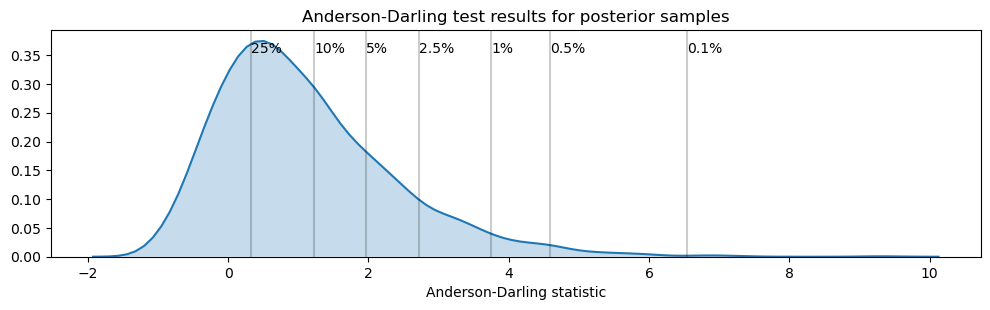

In [45]:
f, ax = plt.subplots(nrows=1, figsize=(12, 3), dpi=100)
# plt.sca(ax[0])
plt.title('Anderson-Darling test results for posterior samples')
sns.kdeplot(anderson['value'], label='', shade=True)
print('Thresholds:')
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%', '0.5%', '0.1%'),
    np.stack(anderson['levels'].values).mean(axis=0)
):
    freq = (anderson['value'] >= j).sum() / len(anderson['value'])
    print(f'{i: >10}: {j:.2f}, reject {freq:.0%} of the time')
    plt.axvline(j, color='k', alpha=0.2)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.xlabel('Anderson-Darling statistic');

Therefore we cannot unilaterally reject the hypothesis that the galaxy pitch angles for our sample are uniformly distributed in $\cot$ between the limits present in [Pringle & Dobbs (2019)](https://arxiv.org/pdf/1909.10291.pdf).

**However**, adjusting the limits to be between 10° and 40° provides a strong rejection of the null hypothesis

Thresholds (adjusted limits):
       25%: 0.33, reject 100% of the time
       10%: 1.23, reject 100% of the time
        5%: 1.96, reject 100% of the time
      2.5%: 2.72, reject 100% of the time
        1%: 3.75, reject 100% of the time
      0.5%: 4.59, reject 100% of the time
      0.1%: 6.55, reject 100% of the time


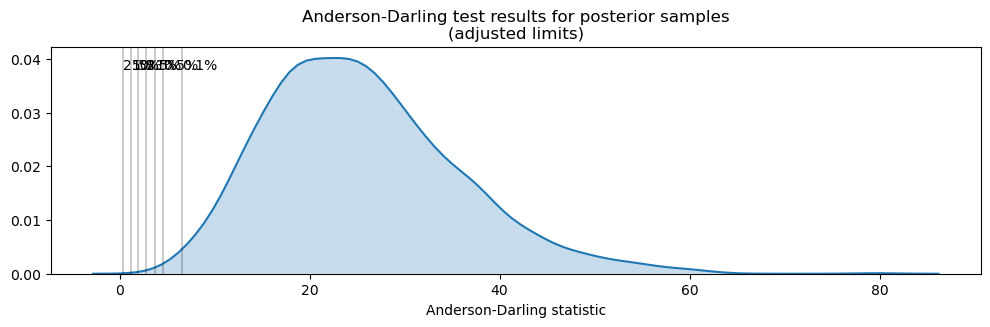

In [46]:
f, ax = plt.subplots(nrows=1, figsize=(12, 3), dpi=100)

# plt.sca(ax[0])
plt.title('Anderson-Darling test results for posterior samples\n(adjusted limits)')
sns.kdeplot(anderson2['value'], label='', shade=True)
print('Thresholds (adjusted limits):')
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%', '0.5%', '0.1%'),
    np.stack(anderson2['levels'].values).mean(axis=0)
):
    freq = (anderson2['value'] >= j).sum() / len(anderson2['value'])
    print(f'{i: >10}: {j:.2f}, reject {freq:.0%} of the time')
    plt.axvline(j, color='k', alpha=0.2)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.xlabel('Anderson-Darling statistic');

The Pringle and Dobbs limits fall somewhere inbetween:

Thresholds (adjusted limits):
       25%: 0.33, reject 100% of the time
       10%: 1.23, reject 100% of the time
        5%: 1.96, reject 100% of the time
      2.5%: 2.72, reject 99% of the time
        1%: 3.75, reject 98% of the time
      0.5%: 4.59, reject 95% of the time
      0.1%: 6.55, reject 86% of the time


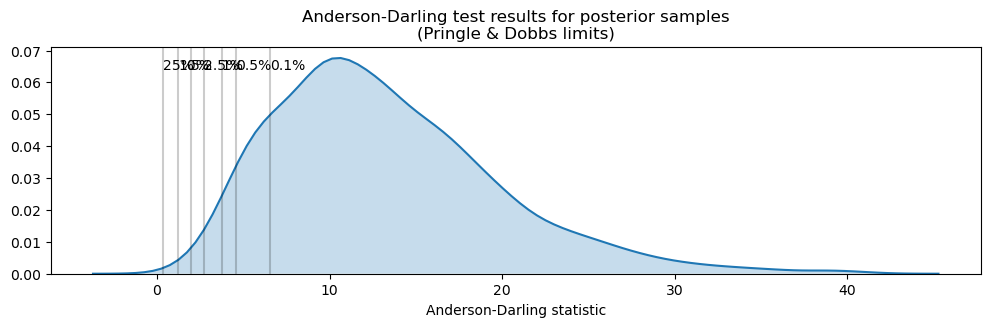

In [47]:
f, ax = plt.subplots(nrows=1, figsize=(12, 3), dpi=100)

# plt.sca(ax[0])
plt.title('Anderson-Darling test results for posterior samples\n(Pringle & Dobbs limits)')
sns.kdeplot(anderson_pringle['value'], label='', shade=True)
print('Thresholds (adjusted limits):')
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%', '0.5%', '0.1%'),
    np.stack(anderson_pringle['levels'].values).mean(axis=0)
):
    freq = (anderson_pringle['value'] >= j).sum() / len(anderson_pringle['value'])
    print(f'{i: >10}: {j:.2f}, reject {freq:.0%} of the time')
    plt.axvline(j, color='k', alpha=0.2)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.xlabel('Anderson-Darling statistic');

Interestingly, the observed pitch angles could definitely be drawn from a scaled Beta distribution

$$\phi_\mathrm{gal} \sim 90 \times \mathrm{Beta}(a,\ b).$$

A normal distribution truncated between 0 and 90 is also a good candidate;

$$\phi_\mathrm{gal} \sim \mathrm{TruncatedNormal}(\mu,\ \sigma,\ \mathrm{lower}=0,\ \mathrm{upper}=90).$$

We illustrate the different potential source distributions using their fitted values for each draw (apart from the cot-uniform, which for convenience is a histogram of points sampled from the distribution)

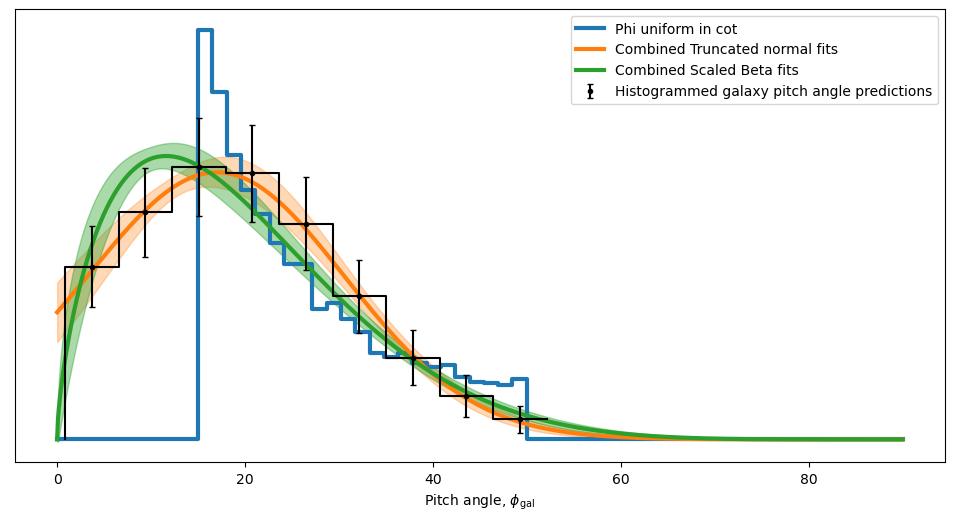

In [22]:
_x = np.linspace(0, 90, 1000)
truncnorm_evals = np.array([t.pdf(_x) for t in truncnorms])
beta_evals = np.array([b.pdf(_x) for b in betas])

# scale factor for cot distribution so that it appears on the same size as 
# the histogram
sf = len(
    gal_pa_samples
    .unstack()
    .where(lambda a: (a > lower_phi_bound)&(a < upper_phi_bound))
    .dropna()
) / gal_pa_samples.size

plt.figure(figsize=(12, 6), dpi=100)
cot_counts, cot_bins = np.histogram(acot(comparison_dataset), density=True, bins='scott')
ct_l = plt.step(
    np.concatenate(([0], cot_bins, [90])),
    np.concatenate(([0, 0], cot_counts, [0])) * sf,
    color='C0', label='Phi uniform in cot', lw=3
)
tn_mns = truncnorm_evals.mean(axis=0)
tn_stds = truncnorm_evals.std(axis=0)
tn_l = plt.plot(_x, tn_mns, c='C1', lw=3, label='Combined Truncated normal fits')
plt.fill_between(
    _x,
    tn_mns - tn_stds,
    tn_mns + tn_stds,
    color='C1', alpha=0.3
)
bt_l = plt.plot(_x, beta_evals.mean(axis=0), c='C2', lw=3, label='Combined Scaled Beta fits')
bt_mns = beta_evals.mean(axis=0)
bt_stds = beta_evals.std(axis=0)
plt.fill_between(
    _x,
    bt_mns - bt_stds,
    bt_mns + bt_stds,
    color='C2', alpha=0.4
)

# plot a histogram with errors of the posterior realizations used to fit things
counts, bins = np.histogram(gal_pa_samples.T.iloc[0], bins='auto', density=True)

res = pd.DataFrame([], columns=np.concatenate((bins[:-1] + np.diff(bins) / 2, (90,))), index=gal_pa_samples.index)
for idx, val in gal_pa_samples.iteritems():
    counts, _ = np.histogram(val, bins=bins, density=True)
    res.loc[idx] = pd.Series(counts, index=bins[:-1] + np.diff(bins) / 2)

l_data = plt.errorbar(
    res.columns, res.mean(), yerr=res.std(),
    fmt='.', color='k',
    label='Histogrammed galaxy pitch angle predictions',
    zorder=3, capsize=2
)

plt.plot(np.concatenate((np.repeat(bins, 2), (90,))), np.concatenate(([0], np.repeat(res.mean(), 2).values)), c='k')
plt.legend()
plt.xlabel(r'Pitch angle, $\phi_\mathrm{gal}$')
plt.yticks([]);
plt.savefig('plots/distribution_comparison.pdf', bbox_inches='tight')

## What about on an arm-by-arm basis?

If arms form and wind independently of each other, we would expect arm pitch angle to be uniformly distributed in cot, and not (necessarily) the pitch angle of a galaxy as a whole.

In [23]:
LOWER_COT_BOUND_ARM = LOWER_COT_BOUND  # = cot(50)
UPPER_COT_BOUND_ARM = UPPER_COT_BOUND  # = cot(15)

lower_phi_bound_arm = acot(UPPER_COT_BOUND_ARM)
upper_phi_bound_arm = acot(LOWER_COT_BOUND_ARM)
print(f'{LOWER_COT_BOUND_ARM:.2f} < cot(ɸ) < {UPPER_COT_BOUND_ARM:.2f}')
print(f'{lower_phi_bound_arm:.2f} < ɸ < {upper_phi_bound_arm:.2f}')

0.84 < cot(ɸ) < 3.73
15.00 < ɸ < 50.00


In [24]:
# Test against cot-uniform
ks_arm = pd.Series([], name='ks_test_result', dtype=object)
anderson_arm = pd.Series([], name='anderson_test_result', dtype=object)
arm_cot_target_dist = st.uniform(LOWER_COT_BOUND_ARM, UPPER_COT_BOUND_ARM - LOWER_COT_BOUND_ARM)
arm_comparison_dataset = arm_cot_target_dist.rvs(10000)

with tqdm(range(trace['phi_arm'].shape[0])) as bar:
    for i in bar:
        phi_arm_est = trace['phi_arm'][i]
        cot_phi_arm_est = cot(phi_arm_est)
        cot_mask = (cot_phi_arm_est > LOWER_COT_BOUND_ARM) & (cot_phi_arm_est < UPPER_COT_BOUND_ARM)
        anderson_arm[i] = st.anderson_ksamp((
            cot_phi_arm_est[cot_mask],
            arm_comparison_dataset,
        ))
        ks_arm[i] = st.kstest(
            cot_phi_arm_est[cot_mask],
            arm_cot_target_dist.cdf,
        )

ks_arm = ks_arm.apply(pd.Series).rename(columns={0: 'value', 1: 'p'})
anderson_arm = anderson_arm.apply(pd.Series).rename(columns={0: 'value', 1: 'levels', 2: 'significance'})

100%|██████████| 2000/2000 [00:14<00:00, 134.97it/s]


In [25]:
rejection_frac = pd.Series([
    (anderson_arm['value'] >= j).sum() / len(anderson['value'])
    for j in np.stack(anderson_arm['levels'].values).mean(axis=0)
], index=('25%', '10%', '5%', '2.5%', '1%', '0.5%', '0.1%'))

Thresholds:
       25%: 0.33, reject 99% of the time
       10%: 1.23, reject 19% of the time
        5%: 1.96, reject 0% of the time
      2.5%: 2.72, reject 0% of the time
        1%: 3.75, reject 0% of the time
      0.5%: 4.59, reject 0% of the time
      0.1%: 6.55, reject 0% of the time


Text(0.5, 0, 'Anderson-Darling statistic')

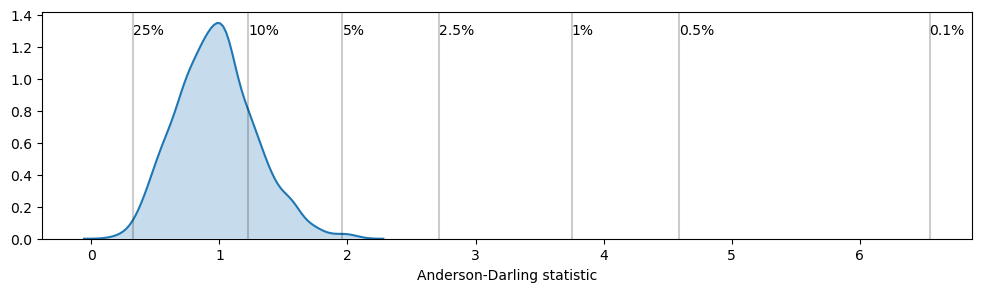

In [26]:
f, ax = plt.subplots(nrows=1, figsize=(12, 3), dpi=100)
# plt.sca(ax[0])
sns.kdeplot(anderson_arm['value'], label='', shade=True)
print('Thresholds:')
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%', '0.5%', '0.1%'),
    np.stack(anderson_arm['levels'].values).mean(axis=0)
):
    print(f'{i: >10}: {j:.2f}, reject {rejection_frac.loc[i]:.0%} of the time')
    plt.axvline(j, color='k', alpha=0.2)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.xlabel('Anderson-Darling statistic')

We'll also plot the resulting fit, scaling the histogram such that the histograms match (densities within bounds add up to one)

In [27]:
sf_gal = len(gal_pa_samples.T.where(lambda a: (a > lower_phi_bound_arm)&(a < upper_phi_bound_arm)).unstack().dropna()) / gal_pa_samples.size
sf_arm = len(arm_pa_samples.T.where(lambda a: (a > lower_phi_bound_arm)&(a < upper_phi_bound_arm)).unstack().dropna()) / arm_pa_samples.size

In [28]:
def get_sample_hist(samples):
    # Each row is a sample, each column is a pitch angle
    counts, bins = np.histogram(
        samples.mean(axis=0),
        bins='scott', density=True
    )
    cols = bins[:-1] + np.diff(bins) / 2
    res = pd.DataFrame([], columns=cols, index=samples.index)
    for sample_idx, vals in samples.iterrows():
        counts, _ = np.histogram(vals, bins=bins, density=True)
        res.loc[sample_idx] = pd.Series(counts, index=cols)
    return bins, res

gal_bins, gal_res = get_sample_hist(gal_pa_samples.T)
arm_bins, arm_res = get_sample_hist(arm_pa_samples.T)

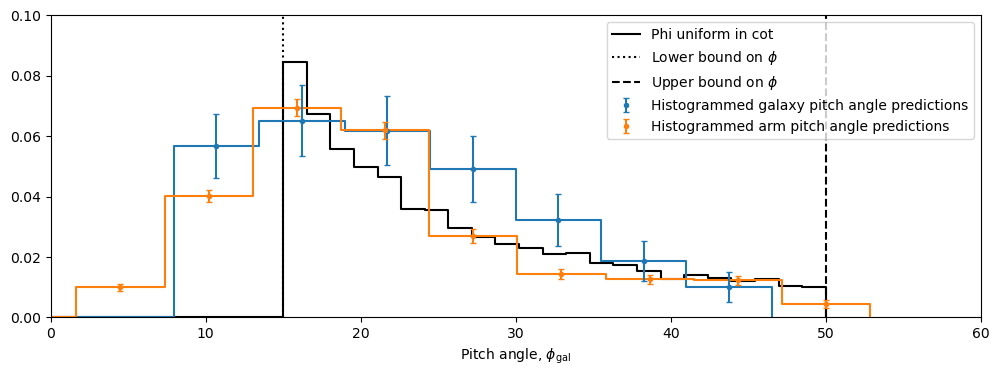

In [29]:
_x = np.linspace(0, 90, 1000)
plt.figure(figsize=(12, 4), dpi=100)
c, b = np.histogram(acot(arm_comparison_dataset), density=True, bins='scott')
plt.step(np.concatenate(((0,), b)), np.concatenate(((0,), c, (0,))), where='post', c='k', label='Phi uniform in cot')

# plot a histogram with errors of the posterior realizations used to fit things
# counts, bins = np.histogram(arm_pa_samples.T.iloc[0], bins='auto', density=True)
l_data_gal = plt.errorbar(
    gal_res.columns,
    gal_res.mean() / sf_gal,
    yerr=gal_res.std() / sf_gal,
    fmt='.', color='C0',
    label='Histogrammed galaxy pitch angle predictions',
    zorder=3, capsize=2
)
plt.step(
    np.concatenate(([0], gal_bins)),
    np.concatenate(([0], gal_res.mean(), [0])) / sf_gal,
    where='post', c='C0', lw=1.5
)

l_data = plt.errorbar(
    arm_res.columns,
    arm_res.mean() / sf_arm,
    yerr=arm_res.std() / sf_arm,
    fmt='.', color='C1',
    label='Histogrammed arm pitch angle predictions',
    zorder=3, capsize=2
)
plt.step(
    np.concatenate(([0], arm_bins)),
    np.concatenate(([0], arm_res.mean(), [0])) / sf_arm,
    where='post', c='C1', lw=1.5
)

# Uncomment to add bin edges
# [plt.axvline(b, c='C0', alpha=0.2) for b in gal_bins]
# [plt.axvline(b, c='C1', alpha=0.2) for b in arm_bins]

plt.axvline(lower_phi_bound_arm, c='k', ls=':', label=r'Lower bound on $\phi$')
plt.axvline(upper_phi_bound_arm, c='k', ls='--', label=r'Upper bound on $\phi$')
plt.legend()
plt.xlabel(r'Pitch angle, $\phi_\mathrm{gal}$')
plt.ylim(0, 0.1)
plt.xlim(0, 60)
plt.savefig('plots/phi_distribution_comparison.pdf', bbox_inches='tight')
plt.savefig('plots/phi_distribution_comparison.jpg', bbox_inches='tight')

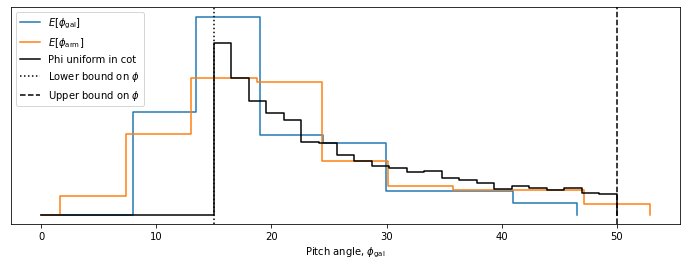

In [30]:
plt.figure(figsize=(12, 4))

e_phi_gal = gal_pa_samples.mean(axis=1)
sf_gal = len(e_phi_gal[np.logical_and(e_phi_gal > lower_phi_bound_arm, e_phi_gal < upper_phi_bound_arm)]) / len(e_phi_gal)
c, b = np.histogram(e_phi_gal, density=True, bins='scott')
plt.step(np.concatenate(((0,), b)), np.concatenate(((0,), c, (0,))) / sf_gal, where='post', label=r'$E[\phi_\mathrm{gal}]$')

e_phi_arm = arm_pa_samples.mean(axis=1)
sf_arm = len(e_phi_arm[np.logical_and(e_phi_arm > lower_phi_bound_arm, e_phi_arm < upper_phi_bound_arm)]) / len(e_phi_arm)
c, b = np.histogram(e_phi_arm, density=True, bins='scott')
plt.step(np.concatenate(((0,), b)), np.concatenate(((0,), c, (0,))) / sf_arm, where='post', label=r'$E[\phi_\mathrm{arm}]$')

c, b = np.histogram(acot(arm_comparison_dataset), density=True, bins='scott')
plt.step(np.concatenate(((0,), b)), np.concatenate(((0,), c, (0,))), where='post', c='k', label='Phi uniform in cot')
plt.legend();

plt.axvline(lower_phi_bound_arm, c='k', ls=':', label=r'Lower bound on $\phi$')
plt.axvline(upper_phi_bound_arm, c='k', ls='--', label=r'Upper bound on $\phi$')
plt.legend()
plt.xlabel(r'Pitch angle, $\phi_\mathrm{gal}$')
plt.yticks([]);
plt.savefig('plots/phi_distribution_comparison_expectation.pdf', bbox_inches='tight')
plt.savefig('plots/phi_distribution_comparison_expectation.jpg', bbox_inches='tight')

Let's compare the results for $\phi_\mathrm{gal}$ and $\phi_\mathrm{arm}$ on the same plot

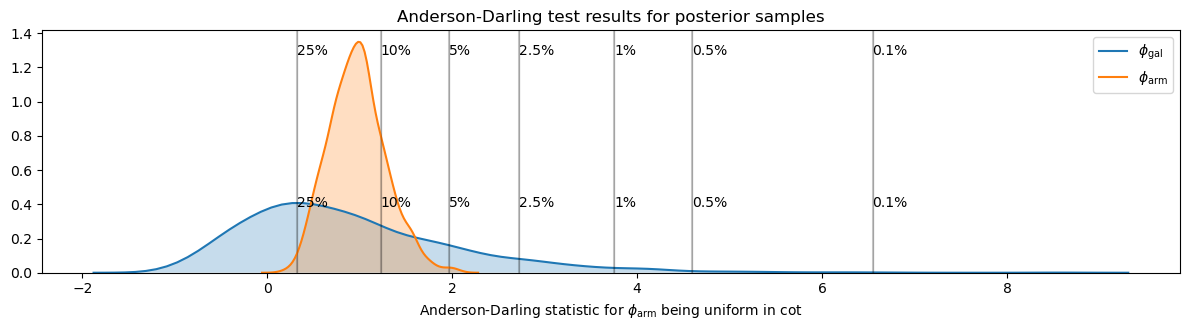

In [31]:
f, ax = plt.subplots(nrows=1, figsize=(12, 3.4), sharex=True, dpi=100)
plt.title('Anderson-Darling test results for posterior samples')
sns.kdeplot(anderson['value'], label=r'$\phi_\mathrm{gal}$', shade=True)
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%', '0.5%', '0.1%'),
    np.stack(anderson['levels'].values).mean(axis=0)
):
    plt.axvline(j, color='k', alpha=0.2)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.xlabel('Anderson-Darling statistic for $\phi_\mathrm{gal}$ being uniform in cot')
sns.kdeplot(anderson_arm['value'], c='C1', label=r'$\phi_\mathrm{arm}$', shade=True)
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%', '0.5%', '0.1%'),
    np.stack(anderson_arm['levels'].values).mean(axis=0)
):
    plt.axvline(j, color='k', alpha=0.2, lw=2 if j == '1%' else 1)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.xlabel('Anderson-Darling statistic for $\phi_\mathrm{arm}$ being uniform in cot')
# [a.set_yticks([]) for a in ax];
plt.tight_layout()
plt.savefig('plots/combined_cot_uniform_marginalized_tests.pdf', bbox_inches='tight')
plt.savefig('plots/combined_cot_uniform_marginalized_tests.jpg', bbox_inches='tight')